In [2]:
import numpy as np
import glob
import cantera as ct
from scipy.interpolate import interp1d
%matplotlib inline

In [3]:

gas = ct.Solution('LUsk17.yaml')
U  = 5.0           # jet exit velocity
d  = 0.03 #0.02          # jet diameter
dTrans = 0.009  #0.004     # tanh transition width 
P = 101325.0       # system pressure

nx_odt = 4000
L_odt  = 1.5

dx_odt = L_odt/nx_odt

L = np.array([0.004, 0.005, 0.006, 0.01, 0.04, 0.1, 0.2, 0.4, 0.8])

#---------------------------------

r = d/2.0;

nf_odt = nx_odt

xf_odt = np.linspace(-L_odt/2,L_odt/2, nx_odt+1)
x_odt = (xf_odt[:-1] + xf_odt[1:])/2
f_odt = np.zeros(nx_odt)
u_odt = np.zeros(nx_odt)

for i in range(nx_odt):
    f_odt[i] = 0.5*(1.0+np.tanh(2.0/dTrans*(x_odt[i]+r))) * \
               0.5*(1.0+np.tanh(2.0/dTrans*(r-x_odt[i])))
    u_odt[i] = f_odt[i]*U

dfdx_odt = np.zeros(nx_odt)
dfdx_odt[0] = (f_odt[1]-f_odt[0])/dx_odt
dfdx_odt[-1] = (f_odt[-1]-f_odt[-2])/dx_odt
dfdx_odt[1:-1] = (f_odt[2:]-f_odt[:-2])/(2*dx_odt)
dfdx_odt = np.abs(dfdx_odt)

#---------------------------------

files = sorted(glob.glob('L_*S*.dat'))
data  = np.loadtxt(files[0])
x     = data[:,0]
dx    = x[1]-x[0]

nL = len(files)
nx = len(data[:,0])
ns = gas.n_species

F = np.zeros((nx,nL))
H = np.zeros((nx,nL))
Y = np.zeros((nx,ns,nL))
X = np.zeros((nx,nL))
T = np.zeros((nx,nL))
dFdX = np.zeros((nx,nL))

for ifile, file in enumerate(files):
    data = np.loadtxt(file)
    X[:,ifile]   = data[:,0]
    F[:,ifile]   = data[:,1]
    H[:,ifile]   = data[:,3]
    T[:,ifile]   = data[:,2]
    Y[:,:,ifile] = data[:,5:5+ns]

    dFdX[0,ifile]  = (F[1,ifile]-F[0,ifile])/(X[1,ifile]-X[0,ifile])
    dFdX[-1,ifile] = (F[-1,ifile]-F[-2,ifile])/(X[-1,ifile]-X[-2,ifile])
    dFdX[1:-1,ifile] = (F[2:,ifile]-F[:-2,ifile])/(X[2:,ifile]-X[:-2,ifile])

#---------------------------------

Hi    = np.zeros((nf_odt,nL))         # H interpolated to f_odt grid
Yi    = np.zeros((nf_odt,ns,nL))      # Y interpolated to f_odt grid
dFdXi = np.zeros((nf_odt,nL))         # dFdX interpolated to f_odt grid

for iL in range(nL):
    ii = interp1d(F[:,iL], H[:,iL])
    Hi[:,iL] = ii(f_odt)
    ii = interp1d(F[:,iL], dFdX[:,iL])
    dFdXi[:,iL] = ii(f_odt)

for iL in range(nL):
    for isp in range(ns):
        ii = interp1d(F[:,iL], Y[:,isp,iL])
        Yi[:,isp,iL] = ii(f_odt)

#---------------------------------

h_odt = np.zeros(nx_odt)
y_odt = np.zeros((nx_odt,ns))

for i in range(nx_odt):               # loop over each odt grid point (x or f)
    ii = interp1d(dFdXi[i,:], Hi[i,:], fill_value='extrapolate')
    h_odt[i] = ii(dfdx_odt[i])
    for k in range(ns):
        ii = interp1d(dFdXi[i,:], Yi[i,k,:], fill_value='extrapolate')
        y_odt[i,k] = ii(dfdx_odt[i])

#---------------------------------

v_odt = np.zeros(nx_odt)
w_odt = np.zeros(nx_odt)
chi_odt = np.zeros(nx_odt)
hr_odt = np.zeros(nx_odt)
rho_odt = np.zeros(nx_odt)
visc_odt = np.zeros(nx_odt)
T_odt = np.zeros(nx_odt)

for i in range(nx_odt):
    gas.HPY = h_odt[i], P, y_odt[i,:]
    T_odt[i] = gas.T
    rho_odt[i] = gas.density
    visc_odt[i] = gas.viscosity



In [4]:
#-------------------- make odt restart file

ofile = open("restart.dat", 'w')

ofile.write("# time = 0\n")
ofile.write(f"# Grid points = {nx_odt}\n")
ofile.write(f"# Pressure (Pa) = {P:.0f}\n")
header = "#             1_pos             2_posf              3_rho            4_dvisc             5_uvel             6_vvel             7_wvel             8_temp             9_mixf             10_chi              11_hr            12_y_H2             13_y_H             14_y_O            15_y_O2            16_y_OH           17_y_H2O           18_y_HO            19_y_CH2        20_y_CH2(S)           21_y_CH3           22_y_CH4            23_y_CO           24_y_CO2           25_y_HCO          26_y_CH2O         27_y_CH2OH            28_y_N2            29_enth\n"

ofile.write(header)

for i in range(nx_odt):
    ofile.write(f"{x_odt[i]:19.10E}")
    ofile.write(f"{xf_odt[i]:19.10E}")
    ofile.write(f"{rho_odt[i]:19.10E}")
    ofile.write(f"{visc_odt[i]:19.10E}")
    ofile.write(f"{u_odt[i]:19.10E}")
    ofile.write(f"{v_odt[i]:19.10E}")
    ofile.write(f"{w_odt[i]:19.10E}")
    ofile.write(f"{T_odt[i]:19.10E}")
    ofile.write(f"{f_odt[i]:19.10E}")
    ofile.write(f"{chi_odt[i]:19.10E}")
    ofile.write(f"{hr_odt[i]:19.10E}")
    for k in range(ns):
        ofile.write(f"{y_odt[i,k]:19.10E}")
    ofile.write(f"{h_odt[i]:19.10E}")
    ofile.write("\n")

ofile.close()

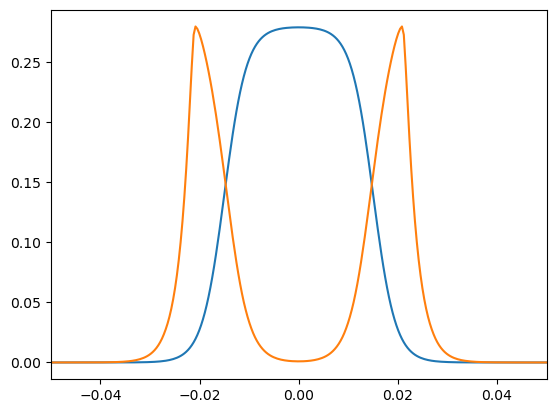

In [5]:
ico2 = gas.species_index('CO2')
ico = gas.species_index('CO')
ih2 = gas.species_index('H2')
ih2o = gas.species_index('H2O')
var = y_odt[:,ico2] + y_odt[:,ico] + y_odt[:,ih2o] + y_odt[:,ih2]
plt.plot(x_odt,f_odt*np.max(var))
plt.plot(x_odt,var)
plt.xlim([-0.05,0.05])

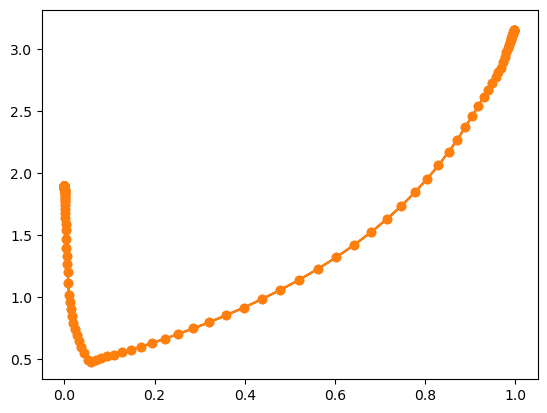

In [6]:
for i in range(1):
    plt.plot(F[:,i],dFdX[:,i]*L[i])
    plt.plot(f_odt,dFdXi[:,i]*L[i], 'o-')

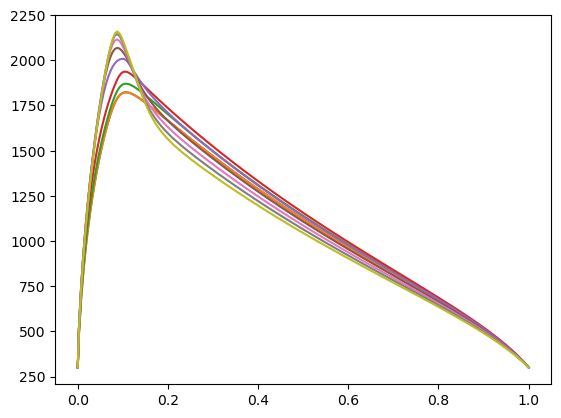

In [7]:
for i in range(nL):
    plt.plot(X[:,i]/L[i],T[:,i])
    #plt.plot(F[:,i],T[:,i])